# DSCI 525 - Web and Cloud Computing
## Milestone 1: Group 01
### Authors:
- Robin Dhillon
- Ritisha Sharma
- Tanmay Agarwal
- Mehdi Neji

## Overview
The purpose of this project is to explore working with Big Data in plain CSV files and `pandas`. We explore many factors such as follows on different machines to understand how Big Data can affect local machines:
- Time taken to download large data files
- Time taken to combine multiple data (.csv) files
- Performing EDA on the combined data in Python
- Effects of changing data types, selecting columns, and loading in chunks on memory and time taken. 
- Performing EDA in R

We use the `figshare` API to obtain data corresponding to daily rainfall for New South Wales, Australia. The dataset is approximately 6GB in size and contains information of rainfall recorded at several weather stations and spans from 1889 to 2014. The dataset can be found [here](https://figshare.com/articles/dataset/Daily_rainfall_over_NSW_Australia/14096681). 

### 1. The Teamwork Contract can be found on Canvas.
### 2. The repository for this project can be found [here](https://github.com/UBC-MDS/525-group-01).
----------------------------------------------------------------------------------------------------------------------------------------

### Imports

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

os.environ['R_HOME'] = '/Users/robin/miniconda3/envs/525_2023/Lib/R'
#!pip install rpy2_arrow
import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

# 3. Downloading the data

## 3.1 Download data from figshare API

In [2]:
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "rainfall/"

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text) 
files = data["files"]            
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

## Extract zip file

In [4]:
%%time
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: total: 3.28 s
Wall time: 2min 16s


In [5]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: total: 15 s
Wall time: 15.1 s


# 4. Combining data CSVs 
## 4.1. All the CSV files are combined into one file
## 4.2. An extra column corresponding to the model is added to the combined csv.

In [2]:
%cd rainfall/

C:\Users\robin\Downloads\MDS\Block 6\DSCI 525\525-group-01\notebooks\rainfall


In [7]:
%%time

files = glob.glob('*.csv')
if "observed_daily_rainfall_SYD.csv" in files:
    files.remove("observed_daily_rainfall_SYD.csv")

if "combined_data.csv" in files:
    os.remove("combined_data.csv")
    files.remove("combined_data.csv")
    
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=re.findall("([^_]*)", file)[0])
                for file in files)
              )
#df.to_csv("combined_data.csv")
with open("combined_data.csv", "w") as f:
    df.to_csv(f)

CPU times: total: 9min 43s
Wall time: 9min 44s


In [8]:
df.model.unique(), df.model.nunique()

(array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR',
        'BCC-ESM1', 'CanESM5', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-ESM2',
        'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-g3', 'GFDL-CM4',
        'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'KIOST-ESM', 'MIROC6',
        'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0',
        'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1'],
       dtype=object),
 27)

## 4.3 Comparison of run times

| Team Member | Operating System | RAM | Processor | Is SSD | Time to combine data CSVs | 
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Tanmay Agarwal    | MacOS   | 16.00 GB    | Apple M1 Pro          |   Yes     |  5min 19s          | 
| Robin Dhillon    |  WinOS   | 16.00 GB | Intel(R) Core(TM) i7-9750h CPU @ 2.60GHz 6 Cores, 12 Logical Processors |  Yes   |  9min 43s  |
| Mehdi Naji    |  WinOS      | 32.00 GB | Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz   1.50 GHz   |   Yes      |    26 min        | 
| Ritisha Sharma    |  WinOS  | 8.00 GB | Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz | Yes | 22min 13s | 

**Discussion**

Depending on the computer, we observe different times taken when combining the csv files into one file. Tanmay's Apple M1 MacOS machine took the shortest amount of time to combine the data, followed by Robin's Windows Machine, Mehdi, and finally Ritisha. This is as expected since Tanmay and I (Robin), have the same amount of RAM but his processor is better, so it takes a shorter amount of time. Although Mehdi has more RAM, his processor is not as good as others so it took him the longestm. Lastly, Ritisha has the least amount of RAM but has a slightly better clock rate on her processor, and hence it took her less time to combine the CSVs than Mehdi. Everyone had a SSD so these results make sense; although we can deduce that if someone had a HDD instead of an SSD, it would have taken even longer for them. It appears that the higher the number of cores and clock-rate of the processor, the less time it takes. The best case would be to have the best processor and the most amount of RAM possible for shorter times. Nonetheless, when the datasets are in 100s of GBs, local machines will not be able to handle them. 

# 5. Load the combined CSV to memory and perform a simple EDA

In [9]:
%%time
combined_df = pd.read_csv("combined_data.csv")
combined_df.memory_usage().sum()/1e6

CPU times: total: 1min 7s
Wall time: 1min 7s


3498.199336

In [10]:
combined_df.head(5)

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-36.25,-35.0,140.625,142.5,3.293256e-13,ACCESS-CM2
1,1889-01-02 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
2,1889-01-03 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
3,1889-01-04 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
4,1889-01-05 12:00:00,-36.25,-35.0,140.625,142.5,1.047658e-02,ACCESS-CM2


In [11]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float64
 2   lat_max        float64
 3   lon_min        float64
 4   lon_max        float64
 5   rain (mm/day)  float64
 6   model          object 
dtypes: float64(5), object(2)
memory usage: 3.3+ GB


In [12]:
print(f"Memory usage with float64 rain and object type time: {combined_df.memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float64 rain and object type time: 3498.20 MB


## 5.1.1. Changing `dtype` of our data.

In [13]:
%%time
combined_df['time'] = pd.to_datetime(combined_df['time'])
combined_df['rain (mm/day)'] = combined_df['rain (mm/day)'].astype(np.float16)
combined_df['lat_min'] = combined_df['lat_min'].astype(np.float16)
combined_df['lat_max'] = combined_df['lat_max'].astype(np.float16)
combined_df['lon_min'] = combined_df['lon_min'].astype(np.float16)
combined_df['lon_max'] = combined_df['lon_max'].astype(np.float16)
combined_df.memory_usage().sum()/1e6

CPU times: total: 32.7 s
Wall time: 32.7 s


1624.164046

In [14]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   time           datetime64[ns]
 1   lat_min        float16       
 2   lat_max        float16       
 3   lon_min        float16       
 4   lon_max        float16       
 5   rain (mm/day)  float16       
 6   model          object        
dtypes: datetime64[ns](1), float16(5), object(1)
memory usage: 1.5+ GB


In [23]:
combined_df["model"].value_counts()

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64

In [15]:
print(f"Memory usage with updated datatypes: {combined_df.memory_usage().sum() / 1e6:.2f} MB")

Memory usage with updated datatypes: 1624.16 MB


Although this might seem insignificant, when we only use the needed columns and apply this datatype, we should see better results. Below, I'll select only the required columns and then do this process again to check.

## 5.1.2. Load just columns that we want

In [3]:
%%time
combined_df2 = pd.read_csv("combined_data.csv", usecols=['time', 'rain (mm/day)', 'model'])

CPU times: total: 1min 8s
Wall time: 1min 9s


In [4]:
print(f"Memory usage with selected columns: {combined_df2.memory_usage().sum() / 1e6:.2f} MB")

Memory usage with selected columns: 1499.23 MB


##### Now, I'll convert the datatypes again (along with column selection) as done before and check how much it makes a difference.

In [5]:
%%time
combined_df2['time'] = pd.to_datetime(combined_df2['time'])
combined_df2['rain (mm/day)'] = combined_df2['rain (mm/day)'].astype(np.float16)
combined_df2.memory_usage().sum()/1e6

CPU times: total: 35.2 s
Wall time: 35.3 s


1124.421302

In [6]:
combined_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   time           datetime64[ns]
 1   rain (mm/day)  float16       
 2   model          object        
dtypes: datetime64[ns](1), float16(1), object(1)
memory usage: 1.0+ GB


In [7]:
print(f"Memory usage with selected columns and datatypes: {combined_df2.memory_usage().sum() / 1e6:.2f} MB")

Memory usage with selected columns and datatypes: 1124.42 MB


As we can see, the memory usage change is significant compared to the original. 

## 5.1.3. Loading in chunks

In [8]:
%%time
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
print(counts.astype(int))

ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
AWI-ESM-1-1-LR       966420
BCC-CSM2-MR         3035340
BCC-ESM1             551880
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
CanESM5              551880
EC-Earth3-Veg-LR    3037320
FGOALS-f3-L         3219300
FGOALS-g3           1287720
GFDL-CM4            3219300
GFDL-ESM4           3219300
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
MIROC6              2070900
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-HR       5154240
MPI-ESM1-2-LR        966420
MRI-ESM2-0          3037320
NESM3                966420
NorESM2-LM           919800
NorESM2-MM          3541230
SAM0-UNICON         3541153
TaiESM1             3541230
dtype: int32
CPU times: total: 1min 25s
Wall time: 1min 26s


## 5.2

| Team Member | Operating System | RAM | Processor | Is SSD |  Load CSV| Change Dtype | Select Columns | Dtype+Columns | Chunks|
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|:----------:|:----------:|:----------:|:----------:|
| Member 1    |  Tanmay Agarwal  | 16.00 GB | Apple M1 Pro |   Yes |   42s | 26.43s | 36.31s | 18.44s | 30.66s|
| Member 2    |  Robin Dhillon   | 16.00 GB | Intel(R) Core(TM) i7-9705h CPU @ 2.60GHz 6 Cores, 12 Logical Processors |  Yes   | 1min 4s  |  32.7 s | 1min 1s | 28.2s | 1min 13s |
| Member 3    |  Mehdi Neji      | 32.00 GB | Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz 1.50 GHz |   Yes | 3min 31s| 4.56s| 34.3s| 25.79s |1min 29 s|
| Member 4    |  Ritisha Sharma  | 8.00 GB | Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz | Yes | 10min 25s | 4min 13s | 7min 2s| 5min 14s |10min |

**Discussion**

Brief summary of observations:
- `Load CSV`: the time taken to load the combined CSV is much shorter than compared to combining, as expected. The trend remains approximately the same, from shortest time to longest: Tanmay > Robin > Mehdi > Ritisha. Although Ritisha had slightly shorter time when combining the CSVs compared to Mehdi, the time to load it is significantly more than him. That could be due to Mehdi's larger RAM. Memory usage is 3.5 Gb.
- `Change dtype`: Changing the datatypes from float64 to float16 has quite a significant effect on the loading times. As we can see for myself (Robin), the time to load decreases by approximately half. Same trend is seen for Tanmay and Ritisha, while for Mehdi it is an astonishing ~5s compared 3.5 minutes before. Again, this could be due to his larger RAM. Memory usage is 1.6Gb. It appears that the memory usage has also be approximately halved which agrees with these observations.
- `Select columns`: Selecting columns doesn't reduce the time by a significant amount for me, Tanmay, and Ritisha. However, the time reduction for Mehdi is again very significant; from 3.5 mins to ~30s. Memory usage is about 1.5GB. This is similar to the previous case but the times are longer. This should be explored more. 
- `Change dtype + select columns`: Now, we combine the above techniques and see that everyone now has even shorter times (except Mehdi who had 4.5s when changing dtype only, this is very interesting). The time reduction has been reduced by mroe than half. Memory usage is a mere 1.1GB now compared to the original 3.5GB. Hence, it is not surprising the times are so short. 
- `Chunks`: Chunking does not lead to a significant decrease in times. 

# Perform a simple EDA in Python

In [9]:
%%time
combined_df2["model"].value_counts()

CPU times: total: 3.58 s
Wall time: 3.61 s


MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64

In [10]:
%%time
df = (pd.DataFrame(
    combined_df2.groupby([combined_df2['time'].dt.year,
                          combined_df2['model']])['rain (mm/day)'].mean()).reset_index())

CPU times: total: 10.1 s
Wall time: 10.2 s


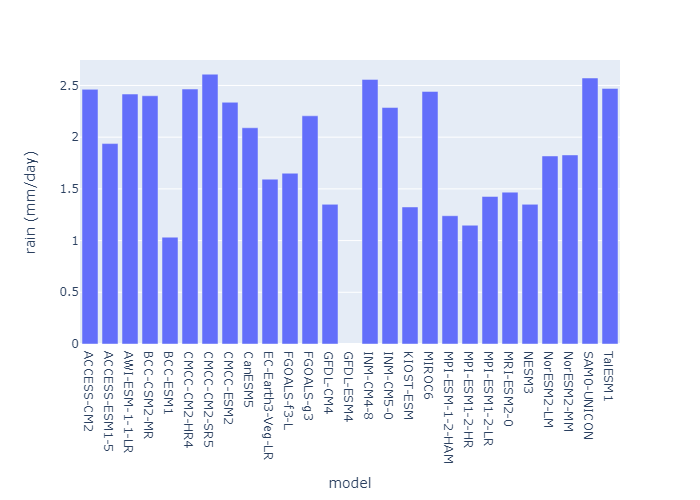

CPU times: total: 672 ms
Wall time: 2.68 s


In [11]:
%%time
year = 2013
fig = px.bar(df[df['time']==year],
             x="model", y="rain (mm/day)")
fig.show()

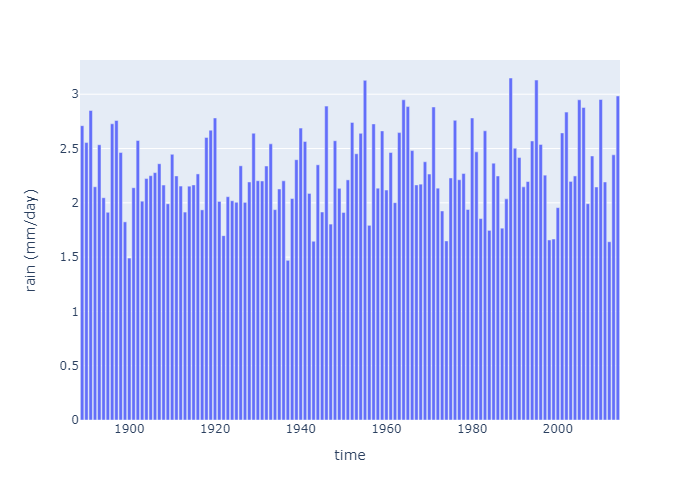

CPU times: total: 46.9 ms
Wall time: 111 ms


In [12]:
%%time
Model = "MIROC6"
fig = px.bar(df[df['model']==Model], x="time", y="rain (mm/day)")
fig.show()

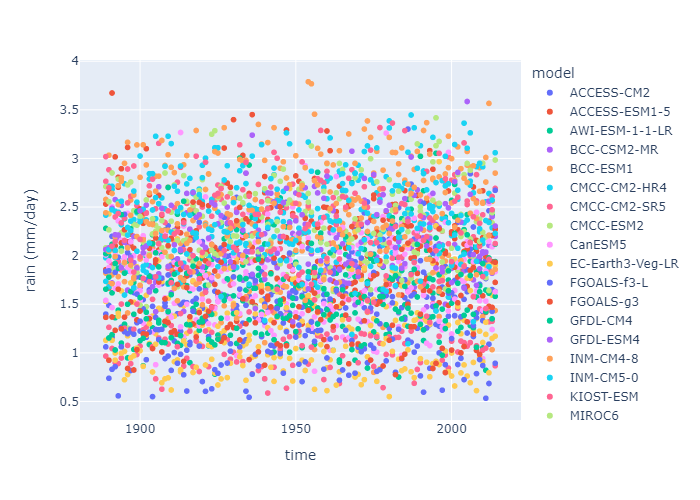

CPU times: total: 172 ms
Wall time: 889 ms


In [13]:
%%time
fig = px.scatter(df, x="time", y="rain (mm/day)", color = "model")
fig.show()

# 6. Perform a simple EDA in R

## 6.1 Arrow exchange

We opted for the Arrow file-format to transfer the dataframe from Python to R. It seemed like an efficient choice since it reads in the data and processes it in chunks as well as in parallel. It also works with any programming language. Furthermore, we chose this because it is much faster and more efficient than using Pandas exchange (which has to serialize and deserialize and that can be time-consuming). Arrow exchange doesn't have these downfalls which is why we chose this method. 

In [2]:
%load_ext rpy2.ipython

C:\Users\robin\miniconda3\envs\525_2023\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning:

The symbol 'quartz' is not in this R namespace/package.



In [3]:
%%time
dataset = ds.dataset("rainfall/combined_data.csv", format="csv")
# Converting the `pyarrow dataset` to a `pyarrow table`
table = dataset.to_table()
# Converting a `pyarrow table` to a `rarrow table`
r_table = pyra.converter.py2rpy(table)

CPU times: total: 27.5 s
Wall time: 25.8 s


In [ ]:
%%time
%%R -i r_table
suppressMessages(library(dplyr))
start_time <- Sys.time()

glimpse(r_table)

end_time <- Sys.time()
print(end_time - start_time)

Table
62,467,843 rows x 7 columns
$ time      <timestamp[s]> 1889-01-01 04:00:00, 1889-01-02 04:00:00, 1889-01-03 ~
$ lat_min         <double> -36.25, -36.25, -36.25, -36.25, -36.25, -36.25, -36.2~
$ lat_max         <double> -35, -35, -35, -35, -35, -35, -35, -35, -35, -35, -35~
$ lon_min         <double> 140.625, 140.625, 140.625, 140.625, 140.625, 140.625,~
$ lon_max         <double> 142.5, 142.5, 142.5, 142.5, 142.5, 142.5, 142.5, 142.~
$ `rain (mm/day)` <double> 3.293256e-13, 0.000000e+00, 0.000000e+00, 0.000000e+0~
$ model           <string> "ACCESS-CM2", "ACCESS-CM2", "ACCESS-CM2", "ACCESS-CM2~
Time difference of 0.1089661 secs


In [ ]:
%%time
%%R -i r_table

start_time <- Sys.time()
suppressMessages(library(dplyr))
r_df <- as.data.frame(r_table)
result <- r_df |> count(model)
    
print(result |>  collect() |> arrange(desc(n)))

end_time <- Sys.time()
print(end_time - start_time)

# A tibble: 27 x 2
   model               n
   <chr>           <int>
 1 MPI-ESM1-2-HR 5154240
 2 CMCC-CM2-HR4  3541230
 3 CMCC-CM2-SR5  3541230
 4 CMCC-ESM2     3541230
 5 NorESM2-MM    3541230
 6 TaiESM1       3541230
 7 SAM0-UNICON   3541153
 8 FGOALS-f3-L   3219300
 9 GFDL-CM4      3219300
10 GFDL-ESM4     3219300
# i 17 more rows
# i Use `print(n = ...)` to see more rows
Time difference of 4.903884 secs


----------------------------------------------------------------------------------------------------------------------------------------

## Problems and Challenges

- Some of the challenges that we faced are described below:
    - Any code chunk that has `%%R` crashes the kernel upon running (this was true for Robin and Ritisha). Simple EDA as shown above indeed runs and the output is shown, but upon displaying the output, the kernel crashes and I had to redo the process again.
    - Despite installing `ggplot2`, the plotting of a simple bar chart would take a very long time and eventually crash the kernel without showing any output. Hence, we removed that cell altogether. 
    - Sometimes, when combining the CSVs or doing EDA in R, the computer would freeze and crash as well while the process was running. 
        - A few times it was taking more than 30 minutes for Ritisha which is when we'd stop the kernel ourselves.
    - Due to these long wait times, debugging of code was quite difficult.

- One way we tackled these challenges was to run parallel on multiple computers: each team member created a separate notebook to record how long it took their computer to perform the operations mentioned above. Then, we used these results to create the tables.

# Summary of Observations
There are large differences in the time it took to combine the data and load it to perform EDA between all the team members. The fastest time to combine the data was 5min 19s with 16.00 GB RAM, Apple M1 Pro processor, and with an SSD. The slowest was 26 min with 32.00 GB RAM, Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz 1.50 GHz, with an SSD. The slowest method of loading the combined CSV was to just naively load it using pandas. Changing the datatype led to a large improvement in performance. Some team members were able to load the data using the improved methods in under a minute